<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

## requirements/CV2 import를 위한 lib 설치/gpu 및 메모리 상태 확인

In [1]:
from IPython.display import clear_output
!pip install -r requirements.txt
!apt-get install libsm6 libxext6 libxrender-dev

clear_output()

!nvidia-smi

Thu Apr 29 07:21:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:00:05.0 Off |                  Off |
| N/A   33C    P0    45W / 250W |      0MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print(f'pytorch version: {torch.__version__}')
print(f'GPU 사용 가능 여부: {torch.cuda.is_available()}')

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [3]:
batch_size = 4   # Mini-batch size
num_epochs = 10
learning_rate = 1e-4

In [4]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 데이터 전처리 함수 정의 (Dataset)

In [5]:
category_names = ['Backgroud', 'UNKNOWN', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [6]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=3,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Using qubvel Pretrained library


In [7]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# aux_params=dict(
#     pooling='avg',             # one of 'avg', 'max'
#     dropout=0.5,               # dropout ratio, default is None
#     activation='sigmoid',      # activation function, default is None
#     classes=12,                 # define number of output labels
# )

preprocess_input = get_preprocessing_fn('timm-efficientnet-b7', pretrained='imagenet')

model = smp.DeepLabV3Plus(
    encoder_name="timm-efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

# model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
model.eval()
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## wandb 설정 및 train, validation, test 함수 정의

In [8]:
import wandb

# Start a new run
wandb.init(project='kwangwon', entity='pstage12')

# Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = learning_rate
config.batch_size = batch_size
config.num_epochs = num_epochs

# Log gradients and model parameters
wandb.watch(model)

wandb: Currently logged in as: pstage12 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
from tqdm import tqdm

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(num_epochs, model, data_loader, val_loader, criterion1, criterion2, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    best_mIoU = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for step, (images, masks, _) in tqdm(enumerate(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            if step + 1 > 653 : #wrong input after 326 iteration
                continue
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산
            loss = criterion1(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # LR schedule 적용
            lr_scheduler.step()
            
            current_lr = get_lr(optimizer)
            
            loss_train_avg = total_loss / (step+1)
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Loss: {loss_train_avg:.4f}, LR: {current_lr}')
                wandb.log({"Train loss": loss_train_avg})
            
            #mIoU at specific step
            #if (step + 1) % 100 == 0:
            #    outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
            #    mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            #    print(f'mIoU: {mIoU:.4f}')
            #    wandb.log({"Train mIoU": mIoU})
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, avrg_mIoU = validation(epoch + 1, model, val_loader, criterion1, criterion2, device)
            if avrg_loss < best_loss: # 둘 중 하나라도 best라면, 저장.
                print(f'mininum loss at epoch: {epoch + 1}')
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)
                
            if avrg_mIoU > best_mIoU:
                print(f'max mIoU at epoch: {epoch + 1}')
                print('Save model in', saved_dir)
                best_mIoU = avrg_mIoU
                save_model(model, saved_dir)

In [9]:
def validation(epoch, model, data_loader, criterion1, criterion2, device):
    print(f'Start validation #{epoch}')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion1(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        avrg_mIoU = np.mean(mIoU_list)
        print(f'Validation #{epoch}  Average Loss: {avrg_loss:.4f}, mIoU: {avrg_mIoU:.4f}')
        wandb.log({"Valid Avg loss": avrg_loss})
        wandb.log({"Valid Avg mIoU": np.mean(mIoU_list)})

    return avrg_loss, avrg_mIoU

## 모델 저장 함수 정의

In [10]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='DeepLabV3Plus_best_model(Effb7_pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [11]:
from torch.autograd import Variable
import torch.nn.functional as F
# ref : https://github.com/clcarwin/focal_loss_pytorch
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [12]:
from madgrad import MADGRAD
# Loss function 정의
criterion1 = FocalLoss()
criterion2 = nn.CrossEntropyLoss()

# Optimizer 정의
#Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
optimizer = MADGRAD(params = model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0, eps = 1e-06)

# Lr_scheculer 정의
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 163, gamma = 0.8)

In [14]:
train(num_epochs, model, train_loader, val_loader, criterion1, criterion2, optimizer, saved_dir, val_every, device)

Start training..


25it [02:02,  4.79s/it]

Epoch [1/10], Step [25/655], Loss: 3.5791, LR: 0.0001


50it [04:05,  4.89s/it]

Epoch [1/10], Step [50/655], Loss: 2.5605, LR: 0.0001


75it [06:11,  4.99s/it]

Epoch [1/10], Step [75/655], Loss: 2.1820, LR: 0.0001


100it [08:15,  4.98s/it]

Epoch [1/10], Step [100/655], Loss: 2.0094, LR: 0.0001


125it [10:17,  4.88s/it]

Epoch [1/10], Step [125/655], Loss: 1.8875, LR: 0.0001


150it [12:17,  4.83s/it]

Epoch [1/10], Step [150/655], Loss: 1.7866, LR: 0.0001


175it [14:19,  4.89s/it]

Epoch [1/10], Step [175/655], Loss: 1.6828, LR: 8e-05


200it [16:23,  5.17s/it]

Epoch [1/10], Step [200/655], Loss: 1.6091, LR: 8e-05


225it [18:26,  4.87s/it]

Epoch [1/10], Step [225/655], Loss: 1.5606, LR: 8e-05


250it [20:31,  5.22s/it]

Epoch [1/10], Step [250/655], Loss: 1.5169, LR: 8e-05


275it [22:36,  5.04s/it]

Epoch [1/10], Step [275/655], Loss: 1.4718, LR: 8e-05


300it [24:40,  4.94s/it]

Epoch [1/10], Step [300/655], Loss: 1.4386, LR: 8e-05


325it [26:47,  4.99s/it]

Epoch [1/10], Step [325/655], Loss: 1.4081, LR: 8e-05


350it [28:51,  4.92s/it]

Epoch [1/10], Step [350/655], Loss: 1.3740, LR: 6.400000000000001e-05


375it [30:58,  4.95s/it]

Epoch [1/10], Step [375/655], Loss: 1.3508, LR: 6.400000000000001e-05


400it [33:02,  4.95s/it]

Epoch [1/10], Step [400/655], Loss: 1.3316, LR: 6.400000000000001e-05


425it [35:09,  5.04s/it]

Epoch [1/10], Step [425/655], Loss: 1.3103, LR: 6.400000000000001e-05


450it [37:13,  4.94s/it]

Epoch [1/10], Step [450/655], Loss: 1.2998, LR: 6.400000000000001e-05


475it [39:18,  5.41s/it]

Epoch [1/10], Step [475/655], Loss: 1.2875, LR: 6.400000000000001e-05


500it [41:21,  4.98s/it]

Epoch [1/10], Step [500/655], Loss: 1.2764, LR: 5.120000000000001e-05


525it [43:27,  4.98s/it]

Epoch [1/10], Step [525/655], Loss: 1.2608, LR: 5.120000000000001e-05


550it [45:32,  5.14s/it]

Epoch [1/10], Step [550/655], Loss: 1.2476, LR: 5.120000000000001e-05


575it [47:34,  4.94s/it]

Epoch [1/10], Step [575/655], Loss: 1.2381, LR: 5.120000000000001e-05


600it [49:39,  4.95s/it]

Epoch [1/10], Step [600/655], Loss: 1.2294, LR: 5.120000000000001e-05


625it [51:41,  4.81s/it]

Epoch [1/10], Step [625/655], Loss: 1.2189, LR: 5.120000000000001e-05


650it [53:44,  4.93s/it]

Epoch [1/10], Step [650/655], Loss: 1.2089, LR: 5.120000000000001e-05


655it [53:58,  4.94s/it]

Start validation #1


Validation #1  Average Loss: 0.7785, mIoU: 0.3564
mininum loss at epoch: 1
Save model in ./saved
max mIoU at epoch: 1
Save model in ./saved


25it [02:06,  5.05s/it]

Epoch [2/10], Step [25/655], Loss: 0.9050, LR: 4.0960000000000014e-05


50it [04:08,  4.89s/it]

Epoch [2/10], Step [50/655], Loss: 0.7576, LR: 4.0960000000000014e-05


75it [06:14,  4.94s/it]

Epoch [2/10], Step [75/655], Loss: 0.7967, LR: 4.0960000000000014e-05


100it [08:19,  5.02s/it]

Epoch [2/10], Step [100/655], Loss: 0.8022, LR: 4.0960000000000014e-05


125it [10:23,  4.89s/it]

Epoch [2/10], Step [125/655], Loss: 0.8015, LR: 4.0960000000000014e-05


150it [12:25,  4.86s/it]

Epoch [2/10], Step [150/655], Loss: 0.8222, LR: 4.0960000000000014e-05


175it [14:28,  4.94s/it]

Epoch [2/10], Step [175/655], Loss: 0.8082, LR: 3.2768000000000016e-05


200it [16:32,  4.91s/it]

Epoch [2/10], Step [200/655], Loss: 0.8140, LR: 3.2768000000000016e-05


225it [18:35,  4.95s/it]

Epoch [2/10], Step [225/655], Loss: 0.8078, LR: 3.2768000000000016e-05


250it [20:38,  5.04s/it]

Epoch [2/10], Step [250/655], Loss: 0.8160, LR: 3.2768000000000016e-05


275it [22:42,  4.96s/it]

Epoch [2/10], Step [275/655], Loss: 0.8014, LR: 3.2768000000000016e-05


300it [24:46,  4.97s/it]

Epoch [2/10], Step [300/655], Loss: 0.8086, LR: 3.2768000000000016e-05


325it [26:48,  4.91s/it]

Epoch [2/10], Step [325/655], Loss: 0.8117, LR: 2.6214400000000015e-05


350it [28:51,  5.09s/it]

Epoch [2/10], Step [350/655], Loss: 0.8151, LR: 2.6214400000000015e-05


375it [30:57,  4.93s/it]

Epoch [2/10], Step [375/655], Loss: 0.8128, LR: 2.6214400000000015e-05


400it [33:01,  4.95s/it]

Epoch [2/10], Step [400/655], Loss: 0.8093, LR: 2.6214400000000015e-05


425it [35:04,  4.92s/it]

Epoch [2/10], Step [425/655], Loss: 0.8032, LR: 2.6214400000000015e-05


450it [37:09,  4.98s/it]

Epoch [2/10], Step [450/655], Loss: 0.8016, LR: 2.6214400000000015e-05


475it [39:12,  4.98s/it]

Epoch [2/10], Step [475/655], Loss: 0.7990, LR: 2.6214400000000015e-05


500it [41:15,  4.87s/it]

Epoch [2/10], Step [500/655], Loss: 0.7981, LR: 2.0971520000000012e-05


525it [43:21,  5.10s/it]

Epoch [2/10], Step [525/655], Loss: 0.7910, LR: 2.0971520000000012e-05


550it [45:25,  4.97s/it]

Epoch [2/10], Step [550/655], Loss: 0.7807, LR: 2.0971520000000012e-05


575it [47:27,  4.97s/it]

Epoch [2/10], Step [575/655], Loss: 0.7762, LR: 2.0971520000000012e-05


600it [49:30,  4.79s/it]

Epoch [2/10], Step [600/655], Loss: 0.7718, LR: 2.0971520000000012e-05


625it [51:32,  4.93s/it]

Epoch [2/10], Step [625/655], Loss: 0.7795, LR: 2.0971520000000012e-05


650it [53:36,  4.96s/it]

Epoch [2/10], Step [650/655], Loss: 0.7829, LR: 2.0971520000000012e-05


655it [53:51,  4.93s/it]

Start validation #2


Validation #2  Average Loss: 0.6992, mIoU: 0.3915
mininum loss at epoch: 2
Save model in ./saved
max mIoU at epoch: 2
Save model in ./saved


25it [02:04,  4.93s/it]

Epoch [3/10], Step [25/655], Loss: 0.5838, LR: 1.677721600000001e-05


50it [04:09,  5.01s/it]

Epoch [3/10], Step [50/655], Loss: 0.5508, LR: 1.677721600000001e-05


75it [06:13,  4.88s/it]

Epoch [3/10], Step [75/655], Loss: 0.5655, LR: 1.677721600000001e-05


100it [08:15,  4.86s/it]

Epoch [3/10], Step [100/655], Loss: 0.5735, LR: 1.677721600000001e-05


125it [10:19,  4.97s/it]

Epoch [3/10], Step [125/655], Loss: 0.5746, LR: 1.677721600000001e-05


150it [12:23,  5.16s/it]

Epoch [3/10], Step [150/655], Loss: 0.6006, LR: 1.677721600000001e-05


175it [14:27,  4.91s/it]

Epoch [3/10], Step [175/655], Loss: 0.6062, LR: 1.3421772800000009e-05


200it [16:31,  4.99s/it]

Epoch [3/10], Step [200/655], Loss: 0.6025, LR: 1.3421772800000009e-05


225it [18:35,  4.96s/it]

Epoch [3/10], Step [225/655], Loss: 0.5930, LR: 1.3421772800000009e-05


250it [20:40,  4.89s/it]

Epoch [3/10], Step [250/655], Loss: 0.5993, LR: 1.3421772800000009e-05


275it [22:43,  4.82s/it]

Epoch [3/10], Step [275/655], Loss: 0.5883, LR: 1.3421772800000009e-05


300it [24:45,  4.94s/it]

Epoch [3/10], Step [300/655], Loss: 0.5890, LR: 1.3421772800000009e-05


325it [26:48,  4.91s/it]

Epoch [3/10], Step [325/655], Loss: 0.5836, LR: 1.0737418240000008e-05


350it [28:52,  5.02s/it]

Epoch [3/10], Step [350/655], Loss: 0.5842, LR: 1.0737418240000008e-05


375it [30:55,  4.83s/it]

Epoch [3/10], Step [375/655], Loss: 0.5779, LR: 1.0737418240000008e-05


400it [32:58,  4.97s/it]

Epoch [3/10], Step [400/655], Loss: 0.5791, LR: 1.0737418240000008e-05


425it [35:02,  4.90s/it]

Epoch [3/10], Step [425/655], Loss: 0.5771, LR: 1.0737418240000008e-05


450it [37:04,  4.90s/it]

Epoch [3/10], Step [450/655], Loss: 0.5744, LR: 1.0737418240000008e-05


475it [39:07,  4.89s/it]

Epoch [3/10], Step [475/655], Loss: 0.5758, LR: 1.0737418240000008e-05


500it [41:10,  4.92s/it]

Epoch [3/10], Step [500/655], Loss: 0.5790, LR: 8.589934592000007e-06


525it [43:15,  5.16s/it]

Epoch [3/10], Step [525/655], Loss: 0.5758, LR: 8.589934592000007e-06


550it [45:19,  5.13s/it]

Epoch [3/10], Step [550/655], Loss: 0.5717, LR: 8.589934592000007e-06


575it [47:23,  4.84s/it]

Epoch [3/10], Step [575/655], Loss: 0.5732, LR: 8.589934592000007e-06


600it [49:26,  4.97s/it]

Epoch [3/10], Step [600/655], Loss: 0.5759, LR: 8.589934592000007e-06


625it [51:29,  4.89s/it]

Epoch [3/10], Step [625/655], Loss: 0.5786, LR: 8.589934592000007e-06


650it [53:34,  5.18s/it]

Epoch [3/10], Step [650/655], Loss: 0.5808, LR: 6.871947673600007e-06


655it [53:49,  4.93s/it]

Start validation #3


Validation #3  Average Loss: 0.6065, mIoU: 0.4064
mininum loss at epoch: 3
Save model in ./saved
max mIoU at epoch: 3
Save model in ./saved


25it [02:04,  4.92s/it]

Epoch [4/10], Step [25/655], Loss: 0.4214, LR: 6.871947673600007e-06


50it [04:09,  4.98s/it]

Epoch [4/10], Step [50/655], Loss: 0.4505, LR: 6.871947673600007e-06


75it [06:12,  4.90s/it]

Epoch [4/10], Step [75/655], Loss: 0.4623, LR: 6.871947673600007e-06


100it [08:19,  5.14s/it]

Epoch [4/10], Step [100/655], Loss: 0.4613, LR: 6.871947673600007e-06


125it [10:19,  4.85s/it]

Epoch [4/10], Step [125/655], Loss: 0.4711, LR: 6.871947673600007e-06


150it [12:22,  4.84s/it]

Epoch [4/10], Step [150/655], Loss: 0.4684, LR: 6.871947673600007e-06


175it [14:25,  4.94s/it]

Epoch [4/10], Step [175/655], Loss: 0.4761, LR: 5.4975581388800055e-06


200it [16:27,  4.85s/it]

Epoch [4/10], Step [200/655], Loss: 0.4698, LR: 5.4975581388800055e-06


225it [18:30,  5.01s/it]

Epoch [4/10], Step [225/655], Loss: 0.4796, LR: 5.4975581388800055e-06


250it [20:33,  4.97s/it]

Epoch [4/10], Step [250/655], Loss: 0.4744, LR: 5.4975581388800055e-06


275it [22:39,  4.94s/it]

Epoch [4/10], Step [275/655], Loss: 0.4725, LR: 5.4975581388800055e-06


300it [24:42,  5.14s/it]

Epoch [4/10], Step [300/655], Loss: 0.4658, LR: 5.4975581388800055e-06


325it [26:44,  5.02s/it]

Epoch [4/10], Step [325/655], Loss: 0.4654, LR: 4.3980465111040045e-06


350it [28:47,  4.84s/it]

Epoch [4/10], Step [350/655], Loss: 0.4661, LR: 4.3980465111040045e-06


375it [30:49,  4.85s/it]

Epoch [4/10], Step [375/655], Loss: 0.4673, LR: 4.3980465111040045e-06


400it [32:54,  5.02s/it]

Epoch [4/10], Step [400/655], Loss: 0.4728, LR: 4.3980465111040045e-06


425it [34:59,  5.00s/it]

Epoch [4/10], Step [425/655], Loss: 0.4736, LR: 4.3980465111040045e-06


450it [37:03,  4.96s/it]

Epoch [4/10], Step [450/655], Loss: 0.4739, LR: 4.3980465111040045e-06


475it [39:06,  4.85s/it]

Epoch [4/10], Step [475/655], Loss: 0.4756, LR: 4.3980465111040045e-06


500it [41:09,  4.89s/it]

Epoch [4/10], Step [500/655], Loss: 0.4744, LR: 3.5184372088832037e-06


525it [43:13,  5.05s/it]

Epoch [4/10], Step [525/655], Loss: 0.4729, LR: 3.5184372088832037e-06


550it [45:16,  4.94s/it]

Epoch [4/10], Step [550/655], Loss: 0.4707, LR: 3.5184372088832037e-06


575it [47:20,  5.02s/it]

Epoch [4/10], Step [575/655], Loss: 0.4737, LR: 3.5184372088832037e-06


600it [49:25,  4.81s/it]

Epoch [4/10], Step [600/655], Loss: 0.4775, LR: 3.5184372088832037e-06


625it [51:25,  4.86s/it]

Epoch [4/10], Step [625/655], Loss: 0.4779, LR: 3.5184372088832037e-06


650it [53:30,  4.97s/it]

Epoch [4/10], Step [650/655], Loss: 0.4804, LR: 2.8147497671065632e-06


655it [53:44,  4.92s/it]

Start validation #4


Validation #4  Average Loss: 0.6072, mIoU: 0.4144
max mIoU at epoch: 4
Save model in ./saved


25it [02:05,  4.96s/it]

Epoch [5/10], Step [25/655], Loss: 0.4649, LR: 2.8147497671065632e-06


50it [04:07,  4.78s/it]

Epoch [5/10], Step [50/655], Loss: 0.4161, LR: 2.8147497671065632e-06


75it [06:09,  4.86s/it]

Epoch [5/10], Step [75/655], Loss: 0.4458, LR: 2.8147497671065632e-06


100it [08:13,  5.00s/it]

Epoch [5/10], Step [100/655], Loss: 0.4407, LR: 2.8147497671065632e-06


125it [10:16,  4.89s/it]

Epoch [5/10], Step [125/655], Loss: 0.4387, LR: 2.8147497671065632e-06


150it [12:21,  4.94s/it]

Epoch [5/10], Step [150/655], Loss: 0.4387, LR: 2.8147497671065632e-06


175it [14:27,  4.98s/it]

Epoch [5/10], Step [175/655], Loss: 0.4448, LR: 2.2517998136852508e-06


200it [16:31,  4.98s/it]

Epoch [5/10], Step [200/655], Loss: 0.4409, LR: 2.2517998136852508e-06


225it [18:33,  4.92s/it]

Epoch [5/10], Step [225/655], Loss: 0.4485, LR: 2.2517998136852508e-06


250it [20:37,  4.81s/it]

Epoch [5/10], Step [250/655], Loss: 0.4442, LR: 2.2517998136852508e-06


275it [22:41,  5.06s/it]

Epoch [5/10], Step [275/655], Loss: 0.4394, LR: 2.2517998136852508e-06


300it [24:44,  4.92s/it]

Epoch [5/10], Step [300/655], Loss: 0.4335, LR: 2.2517998136852508e-06


325it [26:46,  4.89s/it]

Epoch [5/10], Step [325/655], Loss: 0.4301, LR: 1.8014398509482006e-06


350it [28:50,  4.88s/it]

Epoch [5/10], Step [350/655], Loss: 0.4234, LR: 1.8014398509482006e-06


375it [30:55,  5.02s/it]

Epoch [5/10], Step [375/655], Loss: 0.4223, LR: 1.8014398509482006e-06


400it [33:00,  4.86s/it]

Epoch [5/10], Step [400/655], Loss: 0.4232, LR: 1.8014398509482006e-06


425it [35:04,  4.96s/it]

Epoch [5/10], Step [425/655], Loss: 0.4172, LR: 1.8014398509482006e-06


450it [37:08,  4.89s/it]

Epoch [5/10], Step [450/655], Loss: 0.4197, LR: 1.8014398509482006e-06


475it [39:10,  4.91s/it]

Epoch [5/10], Step [475/655], Loss: 0.4190, LR: 1.8014398509482006e-06


500it [41:14,  4.91s/it]

Epoch [5/10], Step [500/655], Loss: 0.4193, LR: 1.4411518807585606e-06


525it [43:20,  4.86s/it]

Epoch [5/10], Step [525/655], Loss: 0.4157, LR: 1.4411518807585606e-06


550it [45:24,  4.92s/it]

Epoch [5/10], Step [550/655], Loss: 0.4161, LR: 1.4411518807585606e-06


575it [47:26,  5.01s/it]

Epoch [5/10], Step [575/655], Loss: 0.4151, LR: 1.4411518807585606e-06


600it [49:29,  4.84s/it]

Epoch [5/10], Step [600/655], Loss: 0.4185, LR: 1.4411518807585606e-06


625it [51:31,  4.87s/it]

Epoch [5/10], Step [625/655], Loss: 0.4197, LR: 1.4411518807585606e-06


650it [53:36,  5.14s/it]

Epoch [5/10], Step [650/655], Loss: 0.4155, LR: 1.1529215046068486e-06


655it [53:51,  4.93s/it]

Start validation #5


Validation #5  Average Loss: 0.5988, mIoU: 0.4227
mininum loss at epoch: 5
Save model in ./saved
max mIoU at epoch: 5
Save model in ./saved


25it [02:03,  4.95s/it]

Epoch [6/10], Step [25/655], Loss: 0.3641, LR: 1.1529215046068486e-06


50it [04:07,  4.99s/it]

Epoch [6/10], Step [50/655], Loss: 0.3836, LR: 1.1529215046068486e-06


75it [06:10,  4.85s/it]

Epoch [6/10], Step [75/655], Loss: 0.3688, LR: 1.1529215046068486e-06


100it [08:13,  4.89s/it]

Epoch [6/10], Step [100/655], Loss: 0.3719, LR: 1.1529215046068486e-06


125it [10:16,  4.99s/it]

Epoch [6/10], Step [125/655], Loss: 0.3655, LR: 1.1529215046068486e-06


150it [12:19,  4.98s/it]

Epoch [6/10], Step [150/655], Loss: 0.3724, LR: 1.1529215046068486e-06


175it [14:23,  4.89s/it]

Epoch [6/10], Step [175/655], Loss: 0.3748, LR: 9.223372036854789e-07


200it [16:28,  4.94s/it]

Epoch [6/10], Step [200/655], Loss: 0.3763, LR: 9.223372036854789e-07


225it [18:30,  4.82s/it]

Epoch [6/10], Step [225/655], Loss: 0.3739, LR: 9.223372036854789e-07


250it [20:33,  5.04s/it]

Epoch [6/10], Step [250/655], Loss: 0.3760, LR: 9.223372036854789e-07


275it [22:34,  4.93s/it]

Epoch [6/10], Step [275/655], Loss: 0.3799, LR: 9.223372036854789e-07


300it [24:34,  4.84s/it]

Epoch [6/10], Step [300/655], Loss: 0.3781, LR: 9.223372036854789e-07


325it [26:33,  4.71s/it]

Epoch [6/10], Step [325/655], Loss: 0.3785, LR: 7.378697629483832e-07


350it [28:36,  4.79s/it]

Epoch [6/10], Step [350/655], Loss: 0.3837, LR: 7.378697629483832e-07


375it [30:36,  4.77s/it]

Epoch [6/10], Step [375/655], Loss: 0.3855, LR: 7.378697629483832e-07


400it [32:35,  4.69s/it]

Epoch [6/10], Step [400/655], Loss: 0.3838, LR: 7.378697629483832e-07


425it [34:34,  4.71s/it]

Epoch [6/10], Step [425/655], Loss: 0.3844, LR: 7.378697629483832e-07


450it [36:39,  5.55s/it]

Epoch [6/10], Step [450/655], Loss: 0.3842, LR: 7.378697629483832e-07


475it [38:40,  4.73s/it]

Epoch [6/10], Step [475/655], Loss: 0.3849, LR: 7.378697629483832e-07


500it [40:39,  4.81s/it]

Epoch [6/10], Step [500/655], Loss: 0.3865, LR: 5.902958103587065e-07


525it [42:38,  4.74s/it]

Epoch [6/10], Step [525/655], Loss: 0.3853, LR: 5.902958103587065e-07


550it [44:39,  4.80s/it]

Epoch [6/10], Step [550/655], Loss: 0.3868, LR: 5.902958103587065e-07


575it [46:41,  4.84s/it]

Epoch [6/10], Step [575/655], Loss: 0.3853, LR: 5.902958103587065e-07


600it [48:41,  4.80s/it]

Epoch [6/10], Step [600/655], Loss: 0.3869, LR: 5.902958103587065e-07


625it [50:42,  4.92s/it]

Epoch [6/10], Step [625/655], Loss: 0.3856, LR: 5.902958103587065e-07


650it [52:44,  4.84s/it]

Epoch [6/10], Step [650/655], Loss: 0.3850, LR: 4.7223664828696525e-07


655it [52:58,  4.85s/it]

Start validation #6


Validation #6  Average Loss: 0.6051, mIoU: 0.4231
max mIoU at epoch: 6
Save model in ./saved


25it [02:03,  4.96s/it]

Epoch [7/10], Step [25/655], Loss: 0.4189, LR: 4.7223664828696525e-07


50it [04:07,  4.98s/it]

Epoch [7/10], Step [50/655], Loss: 0.3773, LR: 4.7223664828696525e-07


75it [06:09,  4.82s/it]

Epoch [7/10], Step [75/655], Loss: 0.3619, LR: 4.7223664828696525e-07


100it [08:12,  4.81s/it]

Epoch [7/10], Step [100/655], Loss: 0.3579, LR: 4.7223664828696525e-07


125it [10:15,  4.89s/it]

Epoch [7/10], Step [125/655], Loss: 0.3523, LR: 4.7223664828696525e-07


150it [12:17,  4.83s/it]

Epoch [7/10], Step [150/655], Loss: 0.3429, LR: 4.7223664828696525e-07


175it [14:20,  4.86s/it]

Epoch [7/10], Step [175/655], Loss: 0.3429, LR: 3.7778931862957223e-07


200it [16:26,  5.16s/it]

Epoch [7/10], Step [200/655], Loss: 0.3395, LR: 3.7778931862957223e-07


225it [18:27,  4.82s/it]

Epoch [7/10], Step [225/655], Loss: 0.3395, LR: 3.7778931862957223e-07


250it [20:32,  4.86s/it]

Epoch [7/10], Step [250/655], Loss: 0.3372, LR: 3.7778931862957223e-07


275it [22:35,  4.95s/it]

Epoch [7/10], Step [275/655], Loss: 0.3427, LR: 3.7778931862957223e-07


300it [24:40,  4.80s/it]

Epoch [7/10], Step [300/655], Loss: 0.3458, LR: 3.7778931862957223e-07


325it [26:43,  4.81s/it]

Epoch [7/10], Step [325/655], Loss: 0.3446, LR: 3.022314549036578e-07


350it [28:45,  4.92s/it]

Epoch [7/10], Step [350/655], Loss: 0.3466, LR: 3.022314549036578e-07


375it [30:49,  4.86s/it]

Epoch [7/10], Step [375/655], Loss: 0.3480, LR: 3.022314549036578e-07


400it [32:53,  4.84s/it]

Epoch [7/10], Step [400/655], Loss: 0.3489, LR: 3.022314549036578e-07


425it [34:55,  4.92s/it]

Epoch [7/10], Step [425/655], Loss: 0.3538, LR: 3.022314549036578e-07


450it [36:57,  4.85s/it]

Epoch [7/10], Step [450/655], Loss: 0.3590, LR: 3.022314549036578e-07


475it [39:00,  5.01s/it]

Epoch [7/10], Step [475/655], Loss: 0.3615, LR: 3.022314549036578e-07


500it [41:02,  4.81s/it]

Epoch [7/10], Step [500/655], Loss: 0.3602, LR: 2.417851639229262e-07


525it [43:04,  4.97s/it]

Epoch [7/10], Step [525/655], Loss: 0.3634, LR: 2.417851639229262e-07


550it [45:08,  4.85s/it]

Epoch [7/10], Step [550/655], Loss: 0.3656, LR: 2.417851639229262e-07


575it [47:08,  4.98s/it]

Epoch [7/10], Step [575/655], Loss: 0.3677, LR: 2.417851639229262e-07


600it [49:11,  4.84s/it]

Epoch [7/10], Step [600/655], Loss: 0.3718, LR: 2.417851639229262e-07


625it [51:11,  4.83s/it]

Epoch [7/10], Step [625/655], Loss: 0.3706, LR: 2.417851639229262e-07


650it [53:14,  4.90s/it]

Epoch [7/10], Step [650/655], Loss: 0.3702, LR: 1.93428131138341e-07


655it [53:29,  4.90s/it]


Start validation #7
Validation #7  Average Loss: 0.6221, mIoU: 0.4062


25it [02:03,  4.95s/it]

Epoch [8/10], Step [25/655], Loss: 0.3342, LR: 1.93428131138341e-07


50it [04:05,  4.88s/it]

Epoch [8/10], Step [50/655], Loss: 0.3544, LR: 1.93428131138341e-07


75it [06:08,  4.92s/it]

Epoch [8/10], Step [75/655], Loss: 0.3489, LR: 1.93428131138341e-07


100it [08:09,  4.80s/it]

Epoch [8/10], Step [100/655], Loss: 0.3540, LR: 1.93428131138341e-07


125it [10:13,  4.88s/it]

Epoch [8/10], Step [125/655], Loss: 0.3531, LR: 1.93428131138341e-07


150it [12:15,  4.87s/it]

Epoch [8/10], Step [150/655], Loss: 0.3526, LR: 1.93428131138341e-07


175it [14:20,  4.80s/it]

Epoch [8/10], Step [175/655], Loss: 0.3611, LR: 1.547425049106728e-07


200it [16:21,  4.85s/it]

Epoch [8/10], Step [200/655], Loss: 0.3547, LR: 1.547425049106728e-07


225it [18:23,  4.82s/it]

Epoch [8/10], Step [225/655], Loss: 0.3519, LR: 1.547425049106728e-07


250it [20:24,  4.81s/it]

Epoch [8/10], Step [250/655], Loss: 0.3501, LR: 1.547425049106728e-07


275it [22:29,  5.05s/it]

Epoch [8/10], Step [275/655], Loss: 0.3548, LR: 1.547425049106728e-07


300it [24:31,  4.96s/it]

Epoch [8/10], Step [300/655], Loss: 0.3588, LR: 1.547425049106728e-07


325it [26:33,  5.04s/it]

Epoch [8/10], Step [325/655], Loss: 0.3594, LR: 1.2379400392853826e-07


350it [28:36,  4.99s/it]

Epoch [8/10], Step [350/655], Loss: 0.3591, LR: 1.2379400392853826e-07


375it [30:41,  5.02s/it]

Epoch [8/10], Step [375/655], Loss: 0.3595, LR: 1.2379400392853826e-07


400it [32:44,  4.86s/it]

Epoch [8/10], Step [400/655], Loss: 0.3622, LR: 1.2379400392853826e-07


425it [34:46,  5.04s/it]

Epoch [8/10], Step [425/655], Loss: 0.3596, LR: 1.2379400392853826e-07


450it [36:49,  4.84s/it]

Epoch [8/10], Step [450/655], Loss: 0.3617, LR: 1.2379400392853826e-07


475it [38:51,  5.11s/it]

Epoch [8/10], Step [475/655], Loss: 0.3592, LR: 1.2379400392853826e-07


500it [40:52,  4.81s/it]

Epoch [8/10], Step [500/655], Loss: 0.3577, LR: 9.903520314283061e-08


525it [42:53,  4.75s/it]

Epoch [8/10], Step [525/655], Loss: 0.3584, LR: 9.903520314283061e-08


550it [44:56,  4.95s/it]

Epoch [8/10], Step [550/655], Loss: 0.3581, LR: 9.903520314283061e-08


575it [47:00,  4.87s/it]

Epoch [8/10], Step [575/655], Loss: 0.3612, LR: 9.903520314283061e-08


600it [49:03,  4.98s/it]

Epoch [8/10], Step [600/655], Loss: 0.3620, LR: 9.903520314283061e-08


625it [51:06,  4.93s/it]

Epoch [8/10], Step [625/655], Loss: 0.3590, LR: 9.903520314283061e-08


650it [53:07,  4.84s/it]

Epoch [8/10], Step [650/655], Loss: 0.3588, LR: 7.922816251426449e-08


655it [53:22,  4.89s/it]

Start validation #8


Validation #8  Average Loss: 0.6053, mIoU: 0.4191


25it [02:02,  4.89s/it]

Epoch [9/10], Step [25/655], Loss: 0.2830, LR: 7.922816251426449e-08


50it [04:05,  4.95s/it]

Epoch [9/10], Step [50/655], Loss: 0.3302, LR: 7.922816251426449e-08


75it [06:08,  4.93s/it]

Epoch [9/10], Step [75/655], Loss: 0.3404, LR: 7.922816251426449e-08


100it [08:11,  4.86s/it]

Epoch [9/10], Step [100/655], Loss: 0.3340, LR: 7.922816251426449e-08


125it [10:13,  4.77s/it]

Epoch [9/10], Step [125/655], Loss: 0.3314, LR: 7.922816251426449e-08


150it [12:16,  4.76s/it]

Epoch [9/10], Step [150/655], Loss: 0.3309, LR: 7.922816251426449e-08


175it [14:16,  4.96s/it]

Epoch [9/10], Step [175/655], Loss: 0.3454, LR: 6.33825300114116e-08


200it [16:17,  4.86s/it]

Epoch [9/10], Step [200/655], Loss: 0.3484, LR: 6.33825300114116e-08


225it [18:20,  4.89s/it]

Epoch [9/10], Step [225/655], Loss: 0.3502, LR: 6.33825300114116e-08


250it [20:23,  4.86s/it]

Epoch [9/10], Step [250/655], Loss: 0.3473, LR: 6.33825300114116e-08


275it [22:23,  4.94s/it]

Epoch [9/10], Step [275/655], Loss: 0.3517, LR: 6.33825300114116e-08


300it [24:25,  4.91s/it]

Epoch [9/10], Step [300/655], Loss: 0.3487, LR: 6.33825300114116e-08


325it [26:27,  4.80s/it]

Epoch [9/10], Step [325/655], Loss: 0.3468, LR: 5.070602400912928e-08


350it [28:29,  4.83s/it]

Epoch [9/10], Step [350/655], Loss: 0.3470, LR: 5.070602400912928e-08


375it [30:33,  4.94s/it]

Epoch [9/10], Step [375/655], Loss: 0.3453, LR: 5.070602400912928e-08


400it [32:37,  4.92s/it]

Epoch [9/10], Step [400/655], Loss: 0.3447, LR: 5.070602400912928e-08


425it [34:40,  4.80s/it]

Epoch [9/10], Step [425/655], Loss: 0.3427, LR: 5.070602400912928e-08


450it [36:41,  4.82s/it]

Epoch [9/10], Step [450/655], Loss: 0.3455, LR: 5.070602400912928e-08


475it [38:44,  4.87s/it]

Epoch [9/10], Step [475/655], Loss: 0.3447, LR: 5.070602400912928e-08


500it [40:49,  4.97s/it]

Epoch [9/10], Step [500/655], Loss: 0.3422, LR: 4.0564819207303424e-08


525it [42:51,  4.89s/it]

Epoch [9/10], Step [525/655], Loss: 0.3428, LR: 4.0564819207303424e-08


550it [44:52,  4.92s/it]

Epoch [9/10], Step [550/655], Loss: 0.3407, LR: 4.0564819207303424e-08


575it [46:54,  4.91s/it]

Epoch [9/10], Step [575/655], Loss: 0.3389, LR: 4.0564819207303424e-08


600it [48:56,  4.83s/it]

Epoch [9/10], Step [600/655], Loss: 0.3391, LR: 4.0564819207303424e-08


625it [50:57,  4.95s/it]

Epoch [9/10], Step [625/655], Loss: 0.3395, LR: 4.0564819207303424e-08


650it [53:01,  4.89s/it]

Epoch [9/10], Step [650/655], Loss: 0.3396, LR: 3.245185536584274e-08


655it [53:16,  4.88s/it]

Start validation #9


Validation #9  Average Loss: 0.6024, mIoU: 0.4203


25it [02:02,  4.92s/it]

Epoch [10/10], Step [25/655], Loss: 0.3261, LR: 3.245185536584274e-08


50it [04:07,  5.11s/it]

Epoch [10/10], Step [50/655], Loss: 0.3177, LR: 3.245185536584274e-08


75it [06:07,  4.77s/it]

Epoch [10/10], Step [75/655], Loss: 0.3597, LR: 3.245185536584274e-08


100it [08:08,  4.84s/it]

Epoch [10/10], Step [100/655], Loss: 0.3658, LR: 3.245185536584274e-08


125it [10:11,  4.91s/it]

Epoch [10/10], Step [125/655], Loss: 0.3574, LR: 3.245185536584274e-08


150it [12:12,  4.87s/it]

Epoch [10/10], Step [150/655], Loss: 0.3496, LR: 3.245185536584274e-08


175it [14:16,  4.87s/it]

Epoch [10/10], Step [175/655], Loss: 0.3438, LR: 2.5961484292674195e-08


200it [16:20,  4.99s/it]

Epoch [10/10], Step [200/655], Loss: 0.3388, LR: 2.5961484292674195e-08


225it [18:24,  4.84s/it]

Epoch [10/10], Step [225/655], Loss: 0.3382, LR: 2.5961484292674195e-08


250it [20:24,  4.76s/it]

Epoch [10/10], Step [250/655], Loss: 0.3382, LR: 2.5961484292674195e-08


275it [22:28,  4.76s/it]

Epoch [10/10], Step [275/655], Loss: 0.3414, LR: 2.5961484292674195e-08


300it [24:30,  4.92s/it]

Epoch [10/10], Step [300/655], Loss: 0.3409, LR: 2.5961484292674195e-08


325it [26:35,  5.45s/it]

Epoch [10/10], Step [325/655], Loss: 0.3386, LR: 2.0769187434139358e-08


350it [28:35,  4.80s/it]

Epoch [10/10], Step [350/655], Loss: 0.3346, LR: 2.0769187434139358e-08


375it [30:38,  4.77s/it]

Epoch [10/10], Step [375/655], Loss: 0.3352, LR: 2.0769187434139358e-08


400it [32:39,  4.81s/it]

Epoch [10/10], Step [400/655], Loss: 0.3300, LR: 2.0769187434139358e-08


425it [34:40,  4.78s/it]

Epoch [10/10], Step [425/655], Loss: 0.3308, LR: 2.0769187434139358e-08


450it [36:42,  4.91s/it]

Epoch [10/10], Step [450/655], Loss: 0.3306, LR: 2.0769187434139358e-08


475it [38:43,  4.84s/it]

Epoch [10/10], Step [475/655], Loss: 0.3312, LR: 2.0769187434139358e-08


500it [40:44,  4.87s/it]

Epoch [10/10], Step [500/655], Loss: 0.3340, LR: 1.6615349947311486e-08


525it [42:44,  4.81s/it]

Epoch [10/10], Step [525/655], Loss: 0.3337, LR: 1.6615349947311486e-08


550it [44:46,  4.82s/it]

Epoch [10/10], Step [550/655], Loss: 0.3344, LR: 1.6615349947311486e-08


575it [46:47,  5.23s/it]

Epoch [10/10], Step [575/655], Loss: 0.3340, LR: 1.6615349947311486e-08


600it [48:50,  4.89s/it]

Epoch [10/10], Step [600/655], Loss: 0.3339, LR: 1.6615349947311486e-08


625it [50:51,  4.86s/it]

Epoch [10/10], Step [625/655], Loss: 0.3333, LR: 1.6615349947311486e-08


650it [52:53,  4.84s/it]

Epoch [10/10], Step [650/655], Loss: 0.3332, LR: 1.329227995784919e-08


655it [53:08,  4.87s/it]

Start validation #10


Validation #10  Average Loss: 0.6018, mIoU: 0.4301
max mIoU at epoch: 10
Save model in ./saved


## 저장된 model 불러오기 (학습된 이후) 

In [13]:
# best model 저장된 경로
model_path = './saved/savefolder/DeepLabV3Plus_best_model(Effb7_pretrained)_focal_loss.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Plastic', 7}]


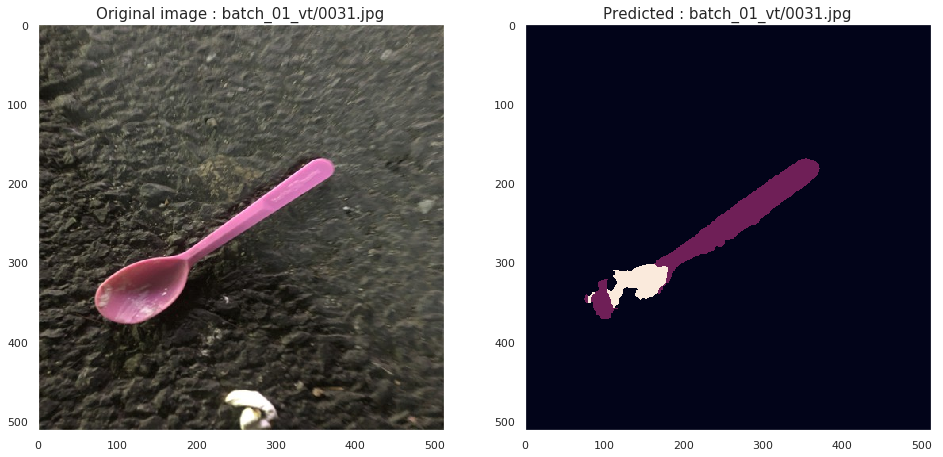

In [14]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 2
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [15]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [16]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/DeepLabV3Plus_best_model(Effb7_pretrained)_focal_loss.csv", index=False)

Start prediction.


279it [29:54,  6.43s/it]


End prediction.


criterion1(outputs, masks) + criterion2(outputs, masks)## Reference

